---
title: "Neural Network Models"
format: 
  html:
    embed-resources: true
---

# Model Architecture Setup

## Import Required Libraries

In [2]:
# Misc libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# PyTorch libraries
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Load Data

In [3]:
full_df = pd.read_csv("../data/clean/absenteeism_model_final.csv")
bss_df = pd.read_csv("../data/clean/absenteeism_model_final_bss.csv")


## Define the Neural Network Models

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a binary classification neural network
class BinaryClassNN(nn.Module):
    def __init__(self, input_size = 14, hidden_layers = [64, 64], output_size = 1, dropout_rate = 0.2):
        super(BinaryClassNN, self).__init__()
        
        self.hidden_layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        # Input layer to first hidden layer
        self.hidden_layers.append(nn.Linear(input_size, hidden_layers[0]))
        self.dropouts.append(nn.Dropout(dropout_rate))

        # Hidden layers
        for i in range(1, len(hidden_layers)):
            self.hidden_layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            self.dropouts.append(nn.Dropout(dropout_rate))

        # Output layer
        self.output_layer = nn.Linear(hidden_layers[-1], output_size)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        for linear, dropout in zip(self.hidden_layers, self.dropouts):
            x = F.relu(linear(x))
            x = dropout(x)
        
        x = self.output_layer(x)
        x = self.activation(x)
        
        return x


# Define a regression neural network
class RegressionNN(nn.Module):
    def __init__(self, input_size = 14, hidden_layers = [64, 64], output_size = 1, dropout_rate = 0.2):
        super(RegressionNN, self).__init__()

        self.hidden_layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        # Input layer to first hidden layer
        self.hidden_layers.append(nn.Linear(input_size, hidden_layers[0]))
        self.dropouts.append(nn.Dropout(dropout_rate))

        # Hidden layers
        for i in range(1, len(hidden_layers)):
            self.hidden_layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            self.dropouts.append(nn.Dropout(dropout_rate))

        # Output layer
        self.output_layer = nn.Linear(hidden_layers[-1], output_size)

    def forward(self, x):
        for linear, dropout in zip(self.hidden_layers, self.dropouts):
            x = F.relu(linear(x))
            x = dropout(x)

        x = self.output_layer(x)

        return x


# Define a multi-class classification neural networks
class MultiClassNN(nn.Module):
    def __init__(self, input_size = 14, hidden_layers = [64, 64], output_size = 3, dropout_rate = 0.2):
        super(MultiClassNN, self).__init__()

        self.hidden_layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        # Input layer to first hidden layer
        self.hidden_layers.append(nn.Linear(input_size, hidden_layers[0]))
        self.dropouts.append(nn.Dropout(dropout_rate))

        # Hidden layers
        for i in range(1, len(hidden_layers)):
            self.hidden_layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            self.dropouts.append(nn.Dropout(dropout_rate))

        # Output layer 
        self.output_layer = nn.Linear(hidden_layers[-1], output_size)

    def forward(self, x):
        for linear, dropout in zip(self.hidden_layers, self.dropouts):
            x = F.relu(linear(x))
            x = dropout(x)

        x = self.output_layer(x)
        x = F.softmax(x, dim = 1)

        return x


## Define the Training Loop

In [14]:
def train_model(model, train_loader, val_loader, optimizer, epochs, patience, model_type, print_epochs = False):
    # Define the loss function
    if model_type == "binary_classification":
        loss_function = nn.BCELoss()
    elif model_type == "multiclass":
        loss_function = nn.CrossEntropyLoss()
    elif model_type == "regression":
        loss_function = nn.MSELoss()
    else:
        raise ValueError("Unsupported model_type")

    # Initialize a previous loss value as a variable to compare validation losses to after each iteration
    previous_val_loss = float("inf")

    # Initialize loss lists and early stopping epochs
    train_losses = []
    val_losses = []
    early_stopping_epochs = 0
    
    # Iterate through epochs
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0

        # Iterate over batches in the training data
        for inputs, labels in train_loader:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs.float())

            if model_type == "multiclass":
                loss = loss_function(outputs, labels.long())
            else:
                labels = labels.view(-1, 1).float()
                loss = loss_function(outputs, labels)

            # Backward pass
            loss.backward()

            # Update model parameters using the optimizer
            optimizer.step()

            # Record the loss for the batch
            running_train_loss += loss.item()
        
        # Get training loss for the epoch
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Set the model to evaluation mode
        model.eval()
        running_val_loss = 0.0

        # Disable gradient calculation for validation
        with torch.no_grad():
            # Iterate over batches in the validation data
            for inputs, labels in val_loader:
                # Forward pass
                outputs = model(inputs.float())

                if model_type == "multiclass":
                    loss = loss_function(outputs, labels.long())
                else:
                    labels = labels.view(-1, 1).float()
                    loss = loss_function(outputs, labels)

                # Record the loss for the batch
                running_val_loss += loss.item()
        
        # Calculate the average validation loss for the epoch
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        if print_epochs == True:
            print(f"Epoch {epoch + 1}: Training Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")
        else:
            pass

        
        # Early stop if validation loss change is below tolerance
        if previous_val_loss > avg_val_loss:
            previous_val_loss = avg_val_loss
            early_stopping_epochs = 0
        else:
            early_stopping_epochs += 1

        # Break the loop if early stopping criteria is met
        if early_stopping_epochs >= patience:
            #print("Early stopping triggered.")
            break

    return train_losses, val_losses

## Define the Hyperparameter Tuning Function

In [15]:
from tqdm import tqdm

def tune_hyperparameters(train_loader, val_loader, params, epochs, patience, model_type, print_epochs = False):
    best_params = None
    best_val_loss = float("inf")
    results = []

    # Calculate total combinations
    total_combinations = (
        len(params["hidden_size"]) *
        len(params["dropout"]) *
        len(params["learning_rate"]) *
        len(params["optimizer"])
    )
    
    # Iterate over all combinations of hyperparameters
    with tqdm(total = total_combinations, desc = "Tuning") as progressbar:
        for hidden_size in tqdm(params["hidden_size"]):
            for dropout in params["dropout"]:
                for learning_rate in params["learning_rate"]:
                    for optimizer_name in params["optimizer"]:
                        #print(f"Hyperparameters: Hidden Layer Size: {hidden_size} | Dropout Rate: {dropout} | Learning Rate: {learning_rate} | Optimizer: {optimizer_name}")

                        # Initialize model with given parameters
                        if model_type == "binary_classification":
                            model = BinaryClassNN(hidden_layers = hidden_size, dropout_rate = dropout)
                        elif model_type == "regression":
                            model = RegressionNN(hidden_layers = hidden_size, dropout_rate = dropout)
                        elif model_type == "multiclass":
                            model = MultiClassNN(hidden_layers = hidden_size, dropout_rate = dropout)
                        else:
                            raise ValueError("Unsupported model_type")
                        

                        # Choose optimizer
                        if optimizer_name == "adam":
                            optimizer = optim.Adam(model.parameters(), lr = learning_rate)

                        elif optimizer_name == "sgd":
                            optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

                        elif optimizer_name == "rmsprop":
                            optimizer = optim.RMSprop(model.parameters(), lr = learning_rate)
                        else: 
                            continue
                        
                        # Train model with current hyperparameters
                        train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, epochs, patience, model_type, print_epochs)

                        # Get final (best) loss value for the run
                        final_train_loss = train_losses[-1] if train_losses else float("inf")
                        final_val_loss = val_losses[-1] if val_losses else float("inf")
                        
                        
                        # Store results
                        results.append({
                            "hidden_size": hidden_size,
                            "dropout": dropout,
                            "learning_rate": learning_rate,
                            "optimizer": optimizer_name,
                            "final_val_loss": final_val_loss
                        })
                        
                        # Update best parameters if a better validation loss value exists
                        if final_val_loss < best_val_loss:
                            best_val_loss = final_val_loss
                            best_params = {
                                "hidden_size": hidden_size,
                                "dropout": dropout,
                                "learning_rate": learning_rate,
                                "optimizer": optimizer_name
                            }
                    
                        # Update progress bar
                        progressbar.update(1)

                    
    
    print("Best Hyperparameters:", best_params)
    print("Best Validation Loss:", best_val_loss)
    
    return best_params, results

# Binary Classification

## Split Data into Training, Validation, and Testing Sets

In [ ]:
# Define the Target and Features columns
x = full_df.drop(columns = ["high_absenteeism", "high_absenteeism_doe", "absenteeism_class", "total_students"])
y = full_df["high_absenteeism"].astype(np.float32)

# Train-val-test split
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size = 0.2)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size = 0.5)


# Data Shape Sanity Check
print("-----Shapes Before Splitting-----")
print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}\n")

print("-----Shapes After Splitting-----")
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}\n")

print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}\n")

print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}\n")


-----Shapes Before Splitting-----
x shape: (12800, 14)
y shape: (12800,)

-----Shapes After Splitting-----
x_train shape: (10240, 14)
y_train shape: (10240,)

x_val shape: (1280, 14)
y_val shape: (1280,)

x_test shape: (1280, 14)
y_test shape: (1280,)



## Normalize Data

In [139]:
# Scale features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.fit_transform(x_val)
x_test = scaler.transform(x_test)

## Create Dataloaders

In [140]:
# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype = torch.float32)
x_val_tensor = torch.tensor(x_val, dtype = torch.float32)
x_test_tensor = torch.tensor(x_test, dtype = torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype = torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype = torch.float32)

# Create datasets and dataloaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

## Tune Hyperparameters

In [142]:
# Define hyperparameter grid
params = {
    "hidden_size": [[128, 128, 128], [256, 256, 256]],
    "dropout": [0.2, 0.3, 0.4],
    "learning_rate": [0.0001, 0.001, 0.01],
    "optimizer": ["adam", "sgd", "rmsprop"]
}

epochs = 30
patience = 3
model_type = "binary_classification"
print_epochs = False

# Run hyperparameter tuning
best_params, tuning_results = tune_hyperparameters(train_loader, val_loader, params, epochs, patience, model_type, print_epochs)

#print(f"Hyper-Parameters Tuning Results")
#print(tuning_results)

Tuning: 100%|██████████| 54/54 [26:36<00:00, 29.56s/it]

Best Hyperparameters: {'hidden_size': [128, 128, 128], 'dropout': 0.3, 'learning_rate': 0.001, 'optimizer': 'rmsprop'}
Best Validation Loss: 0.5109001062810421


## Plot the Training and Validation Loss Curves for the Optimal Model

Epoch 1: Training Loss: 0.5812 | Validation Loss: 0.5429
Epoch 2: Training Loss: 0.5626 | Validation Loss: 0.5435
Epoch 3: Training Loss: 0.5570 | Validation Loss: 0.5352
Epoch 4: Training Loss: 0.5545 | Validation Loss: 0.5382
Epoch 5: Training Loss: 0.5487 | Validation Loss: 0.5345
Epoch 6: Training Loss: 0.5458 | Validation Loss: 0.5251
Epoch 7: Training Loss: 0.5411 | Validation Loss: 0.5323
Epoch 8: Training Loss: 0.5411 | Validation Loss: 0.5270
Epoch 9: Training Loss: 0.5381 | Validation Loss: 0.5239
Epoch 10: Training Loss: 0.5338 | Validation Loss: 0.5206
Epoch 11: Training Loss: 0.5348 | Validation Loss: 0.5212
Epoch 12: Training Loss: 0.5332 | Validation Loss: 0.5170
Epoch 13: Training Loss: 0.5265 | Validation Loss: 0.5202
Epoch 14: Training Loss: 0.5266 | Validation Loss: 0.5140
Epoch 15: Training Loss: 0.5219 | Validation Loss: 0.5314
Epoch 16: Training Loss: 0.5277 | Validation Loss: 0.5189
Epoch 17: Training Loss: 0.5227 | Validation Loss: 0.5114
Epoch 18: Training Loss

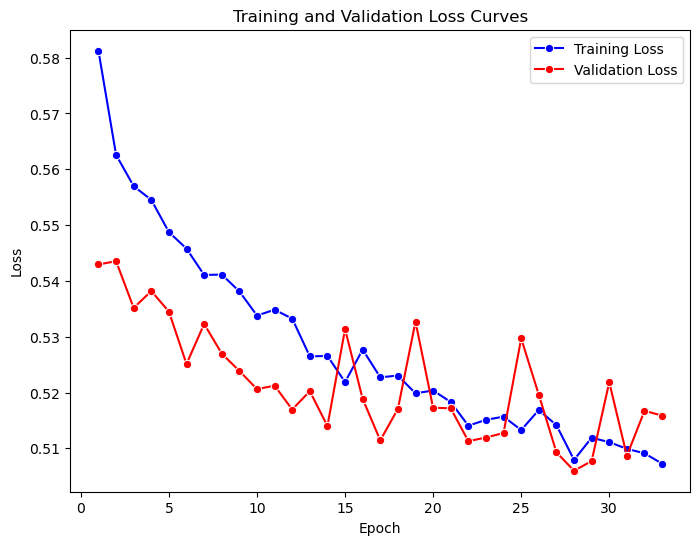

In [143]:
# Intialize the model with the tuned optimal parameters
model = BinaryClassNN(input_size = 14, hidden_layers = best_params["hidden_size"], output_size = 1, dropout_rate = best_params["dropout"])

# Identify the optimal optimizer
if best_params["optimizer"] == "adam":
    optimizer = optim.Adam(model.parameters(), lr = best_params["learning_rate"])

elif best_params["optimizer"] == "sgd":
    optimizer = optim.SGD(model.parameters(), lr = best_params["learning_rate"], momentum = 0.9)
    
elif best_params["optimizer"] == "rmsprop":
    optimizer = optim.RMSprop(model.parameters(), lr = best_params["learning_rate"])

# Determine number of epochs and specify model type
epochs = 100
patience = 5
model_type = "binary_classification"
print_epochs = True

# Train the optimal model
train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, epochs, patience, model_type, print_epochs)

# Plot training and validation losses after all epochs are finished
plt.figure(figsize = (8, 6))
sns.lineplot(x = range(1, len(train_losses) + 1), y = train_losses, label = "Training Loss", marker = "o", linestyle = "-", color = "blue")
sns.lineplot(x = range(1, len(val_losses) + 1), y = val_losses, label = "Validation Loss", marker = "o", linestyle = "-", color = "red")
plt.title("Training and Validation Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Evaluate the Test Set

In [144]:
# Set model to evaluation mode
model.eval()

# Define the loss function
loss_function = nn.BCELoss()

# Initialize variables for tracking loss and predictions
test_loss = 0.0
all_preds = []
all_labels = []

# No gradient calculation during testing
with torch.no_grad():
    # Iterate over the test set
    for inputs, labels in test_loader:
        # Forward pass
        outputs = model(inputs.float())

        # Reshape labels to match output shape
        labels = labels.view(-1, 1).float()
        
        # Calculate loss
        loss = loss_function(outputs, labels.float())
        test_loss += loss.item()
        
        # Store predictions and true labels
        all_preds.extend(outputs.squeeze().cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Average test loss
avg_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss}")

Test Loss: 0.5342292420566082


## Save the Model

In [ ]:
# Save the model
# torch.save(model.state_dict(), "../models/binary_class_model.pt")

## Confusion Matrix

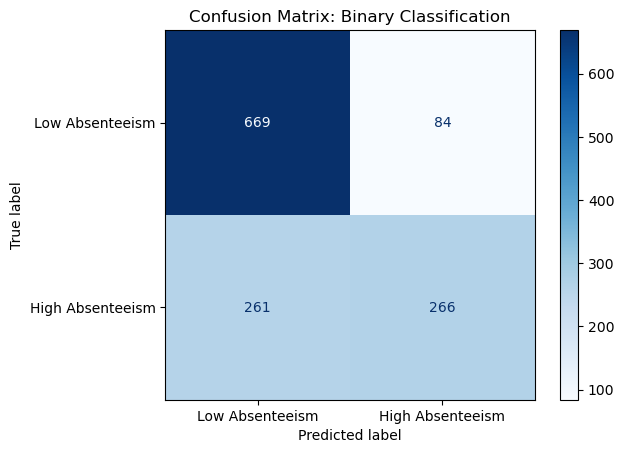

Accuracy: 0.7305
Precision: 0.7600
Recall: 0.5047
F1 Score: 0.6066


In [145]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

# Convert predictions to binary class labels (0 or 1)
preds_binary = []
for p in all_preds:
    if p > 0.5:
        preds_binary.append(1)
    else:
        preds_binary.append(0)

# Create confusion matrix
cm = confusion_matrix(all_labels, preds_binary)

# Plot confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Low Absenteeism", "High Absenteeism"])
cm_display.plot(cmap = "Blues")
plt.title("Confusion Matrix: Binary Classification")
plt.show()


# Compute classification metrics
accuracy = accuracy_score(all_labels, preds_binary)
precision = precision_score(all_labels, preds_binary)
recall = recall_score(all_labels, preds_binary)
f1 = f1_score(all_labels, preds_binary)

# Print classification metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

## ROC Curve

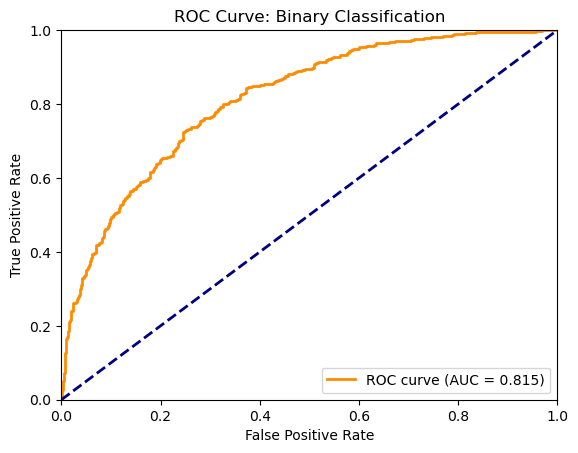

In [147]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color = "darkorange", lw = 2, label = "ROC curve (AUC = %0.3f)" % roc_auc)
plt.plot([0, 1], [0, 1], color = "navy", lw = 2, linestyle = "--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Binary Classification")
plt.legend(loc = "lower right")
plt.show()

## Precision-Recall Curve

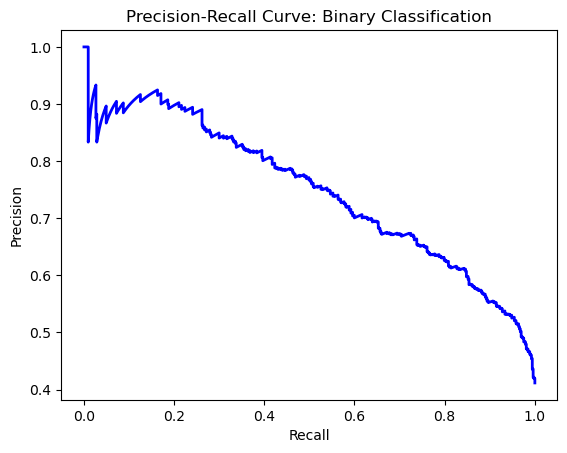

In [148]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(all_labels, all_preds)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color = "blue", lw = 2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve: Binary Classification")
plt.show()

## Model Predicted Probabilities Plot

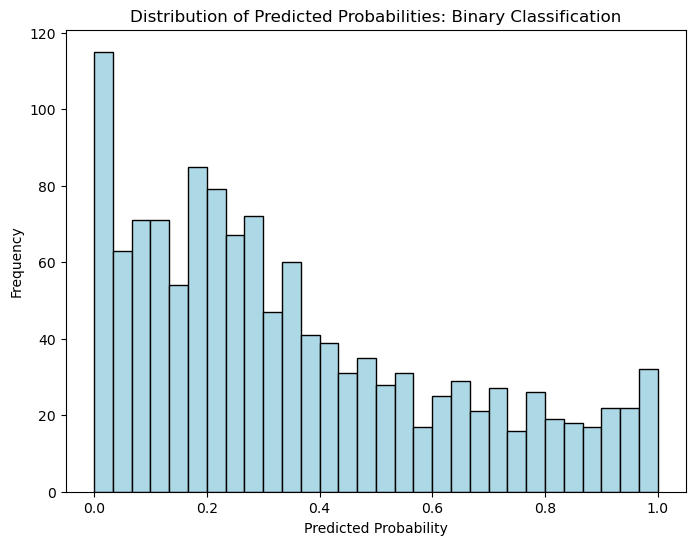

In [149]:
plt.figure(figsize = (8,6))
plt.hist(all_preds, bins = 30, color = "lightblue", edgecolor = "black")
plt.title("Distribution of Predicted Probabilities: Binary Classification")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

# Multi-Class Classification

## Split Data into Training, Validation, and Testing Sets

In [113]:
# Chagne the 3 classes so they're [0, 1, 2] instead of [1, 2, 3]
multi_full_df = full_df
multi_full_df["absenteeism_class"] = multi_full_df["absenteeism_class"] - 1
 
#  Define the Target and Features columns
x = multi_full_df.drop(columns = ["high_absenteeism", "high_absenteeism_doe", "absenteeism_class", "total_students"])
y = multi_full_df["absenteeism_class"].astype(np.float32)

# Train-val-test split
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size = 0.2)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size = 0.5)


# Data Shape Sanity Check
print("-----Shapes Before Splitting-----")
print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}\n")

print("-----Shapes After Splitting-----")
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}\n")

print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}\n")

print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}\n")


-----Shapes Before Splitting-----
x shape: (12800, 14)
y shape: (12800,)

-----Shapes After Splitting-----
x_train shape: (10240, 14)
y_train shape: (10240,)

x_val shape: (1280, 14)
y_val shape: (1280,)

x_test shape: (1280, 14)
y_test shape: (1280,)



## Normalize Data

In [114]:
# Scale features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.fit_transform(x_val)
x_test = scaler.transform(x_test)

## Create Dataloaders

In [115]:
# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype = torch.float32)
x_val_tensor = torch.tensor(x_val, dtype = torch.float32)
x_test_tensor = torch.tensor(x_test, dtype = torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype = torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype = torch.float32)

# Create datasets and dataloaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

## Tune Hyperparameters

In [116]:
# Define hyperparameter grid
params = {
    "hidden_size": [[128, 128], [256, 256], [128, 128, 128], [256, 256, 256]],
    "dropout": [0.3, 0.4],
    "learning_rate": [0.0001, 0.001],
    "optimizer": ["adam", "sgd", "rmsprop"]
}

epochs = 30
patience = 3
model_type = "multiclass"
print_epochs = False

# Run hyperparameter tuning
best_params, tuning_results = tune_hyperparameters(train_loader, val_loader, params, epochs, patience, model_type, print_epochs)


Tuning: 100%|██████████| 48/48 [27:33<00:00, 34.44s/it]

Best Hyperparameters: {'hidden_size': [256, 256, 256], 'dropout': 0.3, 'learning_rate': 0.001, 'optimizer': 'rmsprop'}
Best Validation Loss: 0.9456564977765083


## Plot the Training and Validation Loss Curves for the Optimal Model

Epoch 1: Training Loss: 1.0059 | Validation Loss: 0.9734
Epoch 2: Training Loss: 0.9892 | Validation Loss: 0.9665
Epoch 3: Training Loss: 0.9839 | Validation Loss: 0.9760
Epoch 4: Training Loss: 0.9757 | Validation Loss: 0.9617
Epoch 5: Training Loss: 0.9761 | Validation Loss: 0.9529
Epoch 6: Training Loss: 0.9694 | Validation Loss: 0.9688
Epoch 7: Training Loss: 0.9656 | Validation Loss: 0.9650
Epoch 8: Training Loss: 0.9659 | Validation Loss: 0.9551
Epoch 9: Training Loss: 0.9659 | Validation Loss: 0.9620
Epoch 10: Training Loss: 0.9593 | Validation Loss: 0.9470
Epoch 11: Training Loss: 0.9605 | Validation Loss: 0.9549
Epoch 12: Training Loss: 0.9593 | Validation Loss: 0.9421
Epoch 13: Training Loss: 0.9571 | Validation Loss: 0.9421
Epoch 14: Training Loss: 0.9559 | Validation Loss: 0.9510
Epoch 15: Training Loss: 0.9566 | Validation Loss: 0.9446
Epoch 16: Training Loss: 0.9528 | Validation Loss: 0.9433
Epoch 17: Training Loss: 0.9533 | Validation Loss: 0.9459
Epoch 18: Training Loss

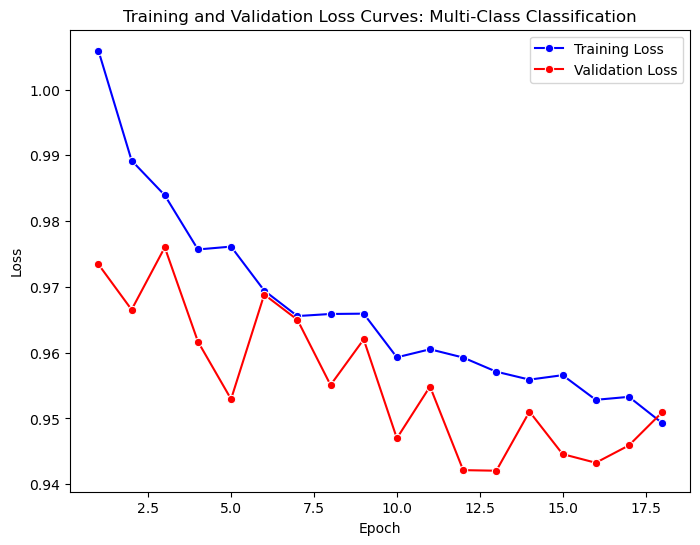

In [117]:
# Intialize the model with the tuned optimal parameters
model = MultiClassNN(input_size = 14, hidden_layers = best_params["hidden_size"], output_size = 3, dropout_rate = best_params["dropout"])

# Identify the optimal optimizer
if best_params["optimizer"] == "adam":
    optimizer = optim.Adam(model.parameters(), lr = best_params["learning_rate"])

elif best_params["optimizer"] == "sgd":
    optimizer = optim.SGD(model.parameters(), lr = best_params["learning_rate"], momentum = 0.9)
    
elif best_params["optimizer"] == "rmsprop":
    optimizer = optim.RMSprop(model.parameters(), lr = best_params["learning_rate"])

# Determine number of epochs and specify model type
epochs = 100
patience = 5
model_type = "multiclass"
print_epochs = True

# Train the optimal model
train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, epochs, patience, model_type, print_epochs)

# Plot training and validation losses after all epochs are finished
plt.figure(figsize = (8, 6))
sns.lineplot(x = range(1, len(train_losses) + 1), y = train_losses, label = "Training Loss", marker = "o", linestyle = "-", color = "blue")
sns.lineplot(x = range(1, len(val_losses) + 1), y = val_losses, label = "Validation Loss", marker = "o", linestyle = "-", color = "red")
plt.title("Training and Validation Loss Curves: Multi-Class Classification")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Evaluate the Test Set

In [122]:
# Set model to evaluation mode
model.eval()

# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Initialize variables for tracking loss and predictions
test_loss = 0.0
all_preds = []
all_labels = []
all_probs = []

# No gradient calculation during testing
with torch.no_grad():

    # Iterate over the test set
    for inputs, labels in test_loader:
        # Forward pass
        outputs = model(inputs.float())

        # Calculate loss
        loss = loss_function(outputs, labels.long())
        test_loss += loss.item()
        
        # Get predicted class by taking the index of the max log-probability
        preds = torch.argmax(outputs, dim = 1)

        # Store softmax probabilities for ROC
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())
        
        # Store predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Average test loss
avg_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss}")

Test Loss: 0.9707588270306587


## Save the Model

In [ ]:
# Save the model
torch.save(model.state_dict(), "../models/multi_class_model.pt")

## Confusion Matrix

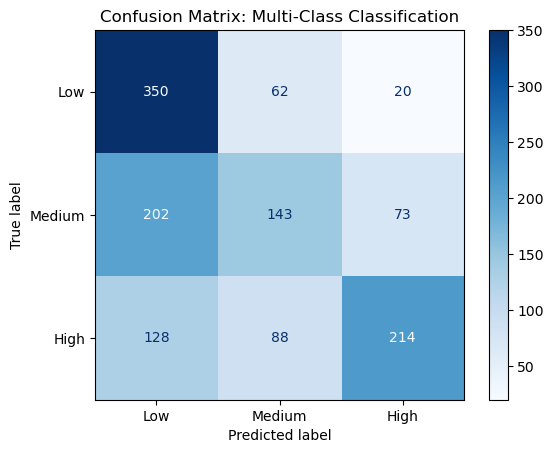

Accuracy: 0.5523
Precision: 0.5673
Recall: 0.5523
F1 Score: 0.5389


In [119]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Low", "Medium", "High"])
cm_display.plot(cmap = "Blues")
plt.title("Confusion Matrix: Multi-Class Classification")
plt.show()

# Compute classification metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average = "weighted")
recall = recall_score(all_labels, all_preds, average = "weighted")
f1 = f1_score(all_labels, all_preds, average = "weighted")

# Print classification metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

## ROC Curve

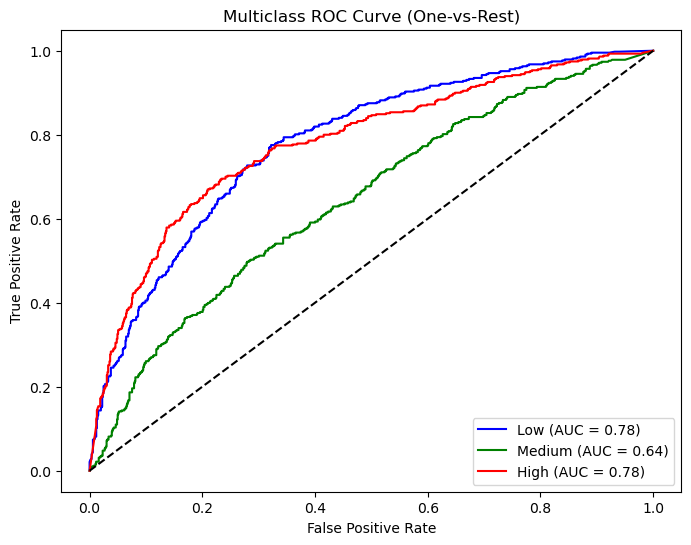

In [132]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# 3 classes
num_classes = len(np.unique(all_labels))

class_names = ["Low", "Medium", "High"]

# Binarize the true labels
y_true_bin = label_binarize(all_labels, classes = list(range(num_classes)))
y_score = np.array(all_probs)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize = (8, 6))
colors = ["blue", "green", "red"]

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color = colors[i % len(colors)],
             label = f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (One-vs-Rest)")
plt.legend(loc = "lower right")
plt.show()

## Precision-Recall Curve

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(all_labels, all_preds)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color = "blue", lw = 2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve: Mulit-Class Classification")
plt.show()

# Linear Regression

## Split Data into Training, Validation, and Testing Sets

In [7]:
full_df = pd.read_csv("../data/clean/absenteeism_model_final.csv")
regression_df = pd.read_csv("../data/clean/cleaned_school_data.csv")

columns_to_keep = full_df.columns.tolist()
columns_to_keep.append("chronic_absentee_ratio")

regression_df = regression_df[columns_to_keep]

In [ ]:
# Define the Target and Features columns
x = regression_df.drop(columns = ["high_absenteeism", "high_absenteeism_doe", "absenteeism_class", "total_students", "chronic_absentee_ratio"])
y = regression_df["chronic_absentee_ratio"].astype(np.float32)

# Train-val-test split
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size = 0.2)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size = 0.5)


# Data Shape Sanity Check
print("-----Shapes Before Splitting-----")
print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}\n")

print("-----Shapes After Splitting-----")
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}\n")

print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}\n")

print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}\n")


-----Shapes Before Splitting-----
x shape: (12800, 14)
y shape: (12800,)

-----Shapes After Splitting-----
x_train shape: (10240, 14)
y_train shape: (10240,)

x_val shape: (1280, 14)
y_val shape: (1280,)

x_test shape: (1280, 14)
y_test shape: (1280,)



## Normalize Data

In [9]:
# Scale features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.fit_transform(x_val)
x_test = scaler.transform(x_test)

## Create Dataloaders

In [10]:
# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype = torch.float32)
x_val_tensor = torch.tensor(x_val, dtype = torch.float32)
x_test_tensor = torch.tensor(x_test, dtype = torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype = torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype = torch.float32)

# Create datasets and dataloaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

## Tune Hyperparameters

In [17]:
# Define hyperparameter grid
params = {
    "hidden_size": [[32, 32], [64, 64], [128, 128]],
    "dropout": [0.3, 0.4,],
    "learning_rate": [0.0001, 0.001],
    "optimizer": ["adam","rmsprop"]
}

epochs = 30
patience = 3
model_type = "regression"
print_epochs = False

# Run hyperparameter tuning
best_params, tuning_results = tune_hyperparameters(train_loader, val_loader, params, epochs, patience, model_type, print_epochs)


Tuning: 100%|██████████| 24/24 [07:14<00:00, 18.08s/it]

Best Hyperparameters: {'hidden_size': [64, 64], 'dropout': 0.3, 'learning_rate': 0.001, 'optimizer': 'rmsprop'}
Best Validation Loss: 0.010758091928437352


## Plot the Training and Validation Loss Curves for the Optimal Model

Epoch 1: Training Loss: 0.0195 | Validation Loss: 0.0136
Epoch 2: Training Loss: 0.0144 | Validation Loss: 0.0125
Epoch 3: Training Loss: 0.0134 | Validation Loss: 0.0121
Epoch 4: Training Loss: 0.0131 | Validation Loss: 0.0118
Epoch 5: Training Loss: 0.0127 | Validation Loss: 0.0120
Epoch 6: Training Loss: 0.0123 | Validation Loss: 0.0118
Epoch 7: Training Loss: 0.0122 | Validation Loss: 0.0115
Epoch 8: Training Loss: 0.0119 | Validation Loss: 0.0116
Epoch 9: Training Loss: 0.0118 | Validation Loss: 0.0111
Epoch 10: Training Loss: 0.0117 | Validation Loss: 0.0112
Epoch 11: Training Loss: 0.0117 | Validation Loss: 0.0115
Epoch 12: Training Loss: 0.0115 | Validation Loss: 0.0111
Epoch 13: Training Loss: 0.0118 | Validation Loss: 0.0109
Epoch 14: Training Loss: 0.0114 | Validation Loss: 0.0115
Epoch 15: Training Loss: 0.0114 | Validation Loss: 0.0115
Epoch 16: Training Loss: 0.0113 | Validation Loss: 0.0109
Epoch 17: Training Loss: 0.0111 | Validation Loss: 0.0111
Epoch 18: Training Loss

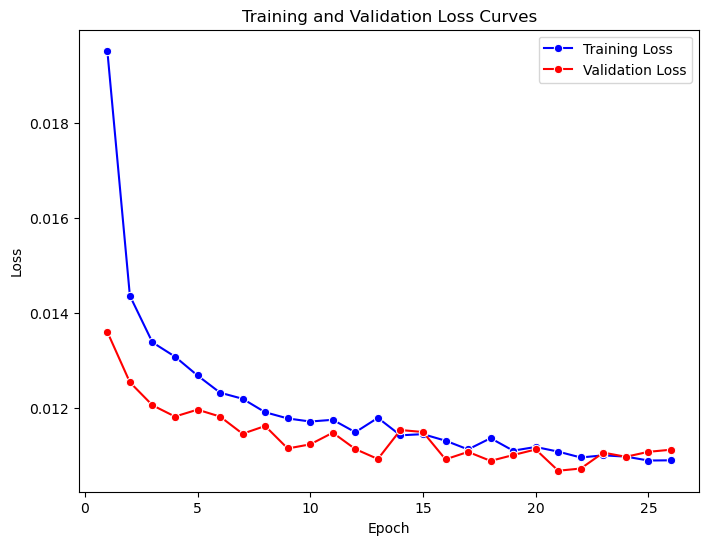

In [ ]:
# Intialize the model with the tuned optimal parameters
model = RegressionNN(input_size = 14, hidden_layers = best_params["hidden_size"], output_size = 1, dropout_rate = best_params["dropout"])

# Identify the optimal optimizer
if best_params["optimizer"] == "adam":
    optimizer = optim.Adam(model.parameters(), lr = best_params["learning_rate"])

elif best_params["optimizer"] == "sgd":
    optimizer = optim.SGD(model.parameters(), lr = best_params["learning_rate"], momentum = 0.9)
    
elif best_params["optimizer"] == "rmsprop":
    optimizer = optim.RMSprop(model.parameters(), lr = best_params["learning_rate"])

# Determine number of epochs and specify model type
epochs = 100
patience = 5
model_type = "regression"
print_epochs = True

# Train the optimal model
train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, epochs, patience, model_type, print_epochs)

# Plot training and validation losses after all epochs are finished
plt.figure(figsize = (8, 6))
sns.lineplot(x = range(1, len(train_losses) + 1), y = train_losses, label = "Training Loss", marker = "o", linestyle = "-", color = "blue")
sns.lineplot(x = range(1, len(val_losses) + 1), y = val_losses, label = "Validation Loss", marker = "o", linestyle = "-", color = "red")
plt.title("Training and Validation Loss Curves: Neural Network Regression")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Evaluate the Test Set

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set model to evaluation mode
model.eval()

# Define the loss function
loss_function = nn.MSELoss()

# Initialize variables for tracking loss and predictions
test_loss = 0.0
all_preds = []
all_targets = []

# No gradient calculation during testing
with torch.no_grad():
    # Iterate over the test set
    for inputs, targets in test_loader:
        # Forward pass
        outputs = model(inputs.float())

        # Reshape labels to match output shape
        targets = targets.view(-1, 1).float()
        
        # Calculate loss
        loss = loss_function(outputs, targets.float())
        test_loss += loss.item()
        
        # Store predictions and true labels
        all_preds.extend(outputs.squeeze().cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Average test loss
avg_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss}\n")


mae = mean_absolute_error(all_targets, all_preds)
mse = mean_squared_error(all_targets, all_preds)
rmse = np.sqrt(mse)
r2 = r2_score(all_targets, all_preds)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Test Loss: 0.01104854594450444

Mean Absolute Error (MAE): 0.0734
Mean Squared Error (MSE): 0.0110
Root Mean Squared Error (RMSE): 0.1051
R² Score: 0.3171


## Save the Model

In [ ]:
# Save the model
#torch.save(model.state_dict(), "../models/regression_model.pt")

## Parity Plot

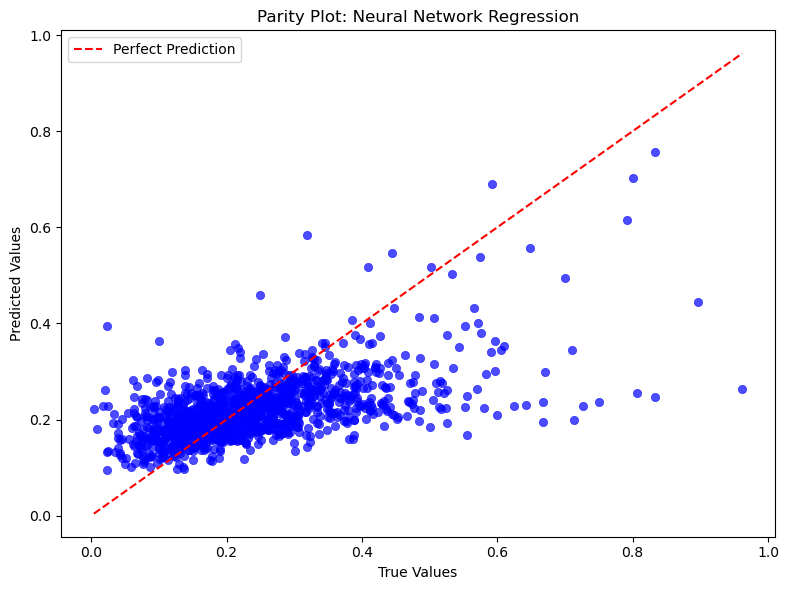

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert to numpy arrays if they aren't already
all_targets = np.array(all_targets).flatten()
all_preds = np.array(all_preds).flatten()

# Create parity plot
plt.figure(figsize = (8, 6))
sns.scatterplot(x = all_targets, y = all_preds, alpha = 0.7, color = "blue", edgecolor = None)

# Add a diagonal reference line
min_val = min(all_targets.min(), all_preds.min())
max_val = max(all_targets.max(), all_preds.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle = "--", color = "red", label = "Perfect Prediction")

# targets and title
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Parity Plot: Neural Network Regression")
plt.legend()
plt.tight_layout()
plt.show()
